In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import json
import gzip
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## Amazon Review Helpfulness 
### Reviews and Meta Data Provided by Julian McAuley
#### R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016
#### J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015
##### Write julian.mcauley@gmail.com to request acsses to the data

In [2]:
food_meta_path = 'meta_Grocery_and_Gourmet_Food.json.gz'
food_reviews_total_path = 'reviews_Grocery_and_Gourmet_Food.json.gz'

### Extract pandas dataframe from the compressed Json files

In [3]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

In [4]:
def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## Create a hold out set of a randomly chosen 10% of all the products in the Grocery Database.

In [6]:
df_food_total = getDF(food_reviews_total_path)

In [7]:
df_food_total.shape

(1297156, 9)

In [9]:
df_food_total.asin.unique().shape

(166049,)

In [10]:
random_asins = np.random.choice(df_food_total.asin.unique(), size = 16604, replace =False)

In [11]:
df_random = df_food_total[df_food_total['asin'].isin(random_asins)]

In [12]:
df_test = df_food_total[~df_food_total['asin'].isin(random_asins)]

### This test dataset contains 90% of the products and 90.4% of the reviews.
#### Seperation is done by product so that intrest in the review can be be examined in the context of the intrest in that product.

In [17]:
df_food_reviews_working = df_test.copy()

In [18]:
df_food_reviews_saved = df_random.copy()

#### Save this particular split to keep the same holdout seperate

In [19]:
#df_food_reviews_saved.to_pickle('ten_prec.pkl')

In [20]:
#df_food_reviews_working.to_pickle("ninety_prec.pkl")

### Holdout the same set of products' descriptions too

In [5]:
df_food_meta = getDF(food_meta_path)

In [9]:
df_holdout_meta = df_food_meta[df_food_meta['asin'].isin(random_asins)]

In [10]:
df_test_meta = df_food_meta[~df_food_meta['asin'].isin(random_asins)]

In [11]:
df_holdout_meta.shape

(16604, 9)

In [12]:
df_test_meta.shape

(155156, 9)

In [13]:
#df_holdout_meta.to_pickle('ten_prec_meta.pkl')

In [14]:
#df_test_meta.to_pickle("ninety_prec_meta.pkl")

In [3]:
#df_holdout_meta = pd.read_pickle("ten_prec_meta.pkl")

### Load the test datasets for filtering and cleanup

In [39]:
df_food_reviews_working = pd.read_pickle("ninety_prec.pkl")

In [40]:
df_food_meta = pd.read_pickle('ninety_prec_meta.pkl')

### Associate each review with the description of the product it is regarding - as well as other metadata for that product

In [41]:
df_food_reviews_working =pd.merge(df_food_reviews_working, df_food_meta, on='asin')


In [42]:
df_food_reviews_working.head(1)

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,description,title,imUrl,related,salesRank,categories,price,brand
0,A1ZQZ8RJS1XVTX,0657745316,gsxrgirl,"[0, 0]",1381449600,"No sugar, no GMO garbage, no fillers that come...",5.0,"10 11, 2013",Best vanilla I've ever had,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,http://ecx.images-amazon.com/images/I/41gFi5h0...,{u'also_viewed': [u'B001GE8N4Y']},{u'Grocery & Gourmet Food': 374004},[[Grocery & Gourmet Food]],NaN,NaN


### Convert the helpful column and review date into usable features

In [43]:
df_food_reviews_working[['help_positive','help_total']] = pd.DataFrame(df_food_reviews_working.helpful.values.tolist())


In [44]:
df_food_reviews_working.help_total.sum()

2246774

In [78]:
df_food_reviews_working['ReviewDate'] = pd.to_datetime(df_food_reviews_working['reviewTime'])


### Get rid of the features we are not going to use in this analysis - many of these, particularly related, salesRank, catagories and price are potentialy useful signal in the future

In [81]:
df_food_reviews_working=df_food_reviews_working.drop(['reviewTime', 'unixReviewTime', 'reviewerID', 
                                                      'helpful','reviewerName', 'related', 'salesRank', 
                                                      'imUrl', 'categories', 'price', 'brand'], axis=1)

## Here we are going to try to define active vs inactive product review sections.
### The purpose of this is to create a subset of "ignored" reviews - ones which are in active review sections with people still activly leaving feedback but were "ignored" and no feedback was left.

In [82]:
df_helpfulness_date_defined= df_food_reviews_working.copy()

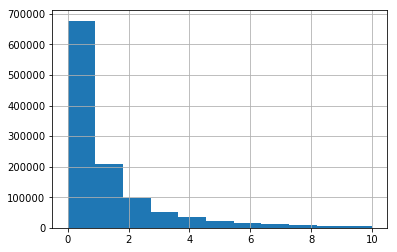

In [83]:
df_helpfulness_date_defined[df_helpfulness_date_defined.help_total<=10].help_total.hist(bins=11)

### Define an active review as one with six or more feedback left regarding it - after 6 the population really starts to tapper off - this "activity indicator" is very tuneable - picking a threshold will do a great deal for determining your model

In [85]:
df_helpfulness_date_defined['volume'] = df_helpfulness_date_defined['help_total'].apply(lambda n: 1 if n >= 6 else 0)

#### Only ~7% of reveiws are able to signal that the product's review section is active 

In [50]:
df_helpfulness_date_defined.groupby("volume").count()["reviewText"] 

volume
0    1093390
1      79190
Name: reviewText, dtype: int64

In [52]:
df_helpfulness_date_defined.shape

(1172580, 10)

## For every product indicate the most recent time its review section had been active with people leave helpfulness feedback on new reviews - many review sections are stagnant, either the receive very little traffic, or are suffering from Early Bird Bias whereby old well received reviews are drowning out newer potentialy more helpful ones

In [53]:
sr_threshold_dates =df_helpfulness_date_defined[df_helpfulness_date_defined['volume'] == 1].groupby('asin')['ReviewDate'].max()

In [54]:
df_threshold =sr_threshold_dates.to_frame()

In [55]:
df_threshold.shape # the number of products which have had at least one "high volume" review

(22794, 1)

### Before this threshold date every review on that product had a chance to get allot of volume - afterall some more recent review on the product managed to acheive some renoun 

In [56]:
df_threshold=df_threshold.reset_index()

In [57]:
df_helpfulness_date_merged=pd.merge(df_helpfulness_date_defined, df_threshold, on='asin')


### Only 15% of products ever have a review with volume however those products contain 64% of all reviews

In [67]:
df_helpfulness_date_merged.asin.unique().shape[0]/float(df_helpfulness_date_defined.asin.unique().shape[0])


0.15252434005821539

In [68]:
df_helpfulness_date_merged.shape[0]/float(df_helpfulness_date_defined.shape[0])

0.6444779887086596

In [69]:
df_helpfulness_date_defined.head(1)

,asin,reviewText,overall,summary,description,title,help_positive,help_total,ReviewDate,volume
0,0657745316,"No sugar, no GMO garbage, no fillers that come...",5.0,Best vanilla I've ever had,This is real vanilla extract made with only 3 ...,100 Percent All Natural Vanilla Extract,0,0,2013-10-11,0


### Seperate out into reviews which have been "seen" or more accuratly have had the chance of achieving volume 

In [71]:
df_helpfulness_viewed =df_helpfulness_date_merged[df_helpfulness_date_merged.ReviewDate_x <= df_helpfulness_date_merged.ReviewDate_y]

In [72]:
df_helpfulness_viewed.shape[0]/float(df_helpfulness_date_defined.shape[0])
# ~28% of reviews have had a change for volume

0.2890856060993706

In [73]:
df_helpfulness_viewed=df_helpfulness_viewed.drop(['ReviewDate_x', 'ReviewDate_y'],axis=1)

In [74]:
df_helpfulness_viewed.head(1)

,asin,reviewText,overall,summary,description,title,help_positive,help_total,volume
0,616719923X,I love green tea anything!!It was a great tast...,4.0,good:)!!,Green Tea Flavor Kit Kat have quickly become t...,Japanese Kit Kat Maccha Green Tea Flavor (5 Ba...,0,0,0


### We are going to compare reviews which have been totally ignored, never received feedback and those that have overwhelmingly positive feedback.  Being able to make this distiction is the difference between helpful and pass - a distiction that can aid in future automated filtering

In [78]:
df_helpfulness_viewed["Ignored"] = (df_helpfulness_viewed["help_total"]).apply(lambda n: 1 if n ==0 else 0)

In [79]:
df_helpfulness_viewed.groupby("volume").count()

,asin,reviewText,overall,summary,description,title,help_positive,help_total,Ignored
volume,,,,,,,,,
0,259786,259786,259786,259786,254368,259174,259786,259786,259786
1,79190,79190,79190,79190,76073,79078,79190,79190,79190


In [80]:
df_helpfulness_viewed['Loved'] = (df_helpfulness_viewed["help_positive"]/
                                  df_helpfulness_viewed["help_total"]).apply(lambda n: 1 if n >= 0.8 else 0)

### For the purposes of this project only Ignored and Overwhelmingly positive reviews will be considered however this consept of activity on a review can lead to the creation of many different classes

In [81]:
# df_helpfulness_viewed['Hated'] = (df_helpfulness_viewed["help_positive"]
#                                   /df_helpfulness_viewed["help_total"]).apply(lambda n: 1 if n <= 0.2 else 0)

In [82]:
df_helpfulness_viewed['Useful'] = np.where(np.logical_and(df_helpfulness_viewed['Loved']==1, df_helpfulness_viewed['volume']==1), 1, 0)


In [83]:
#df_helpfulness_viewed['Toxic'] = np.where(np.logical_and(df_helpfulness_viewed['Hated']==1, df_helpfulness_viewed['Active']==1), 1, 0)


In [84]:
df_helpfulness_viewed['Keeper'] = (df_helpfulness_viewed["Useful"]
                                  +df_helpfulness_viewed["Ignored"]).apply(lambda n: 1 if n >= 1 else 0)

In [93]:
df_keepers = df_helpfulness_viewed[df_helpfulness_viewed['Keeper'] >= 1]

In [94]:
df_keepers.groupby("Useful").count()

,asin,reviewText,overall,summary,description,title,help_positive,help_total,volume,Ignored,Loved,Keeper
Useful,,,,,,,,,,,,
0,125728,125728,125728,125728,123568,125491,125728,125728,125728,125728,125728,125728
1,47174,47174,47174,47174,45278,47130,47174,47174,47174,47174,47174,47174


## Now that the set of reviews for analysis is defined we need to clean the text up before vectorizing it

In [95]:
def cleanup(sentence):
    cleanup_re = re.compile('[^a-z]+')
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence


In [98]:
df_keepers["Text_Clean"] = df_keepers['reviewText'].apply(cleanup)

/anaconda/envs/Python27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [99]:
df_keepers["Summary_Clean"] = df_keepers['summary'].apply(cleanup)

/anaconda/envs/Python27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [100]:
#df_keepers.reset_index()

## Drop all products that don't have descriptions - could swap the title in for the descrption if low on data 

In [101]:
#df_keepers.description.fillna(df_keepers.title, inplace=True)
df_keepers = df_keepers[df_keepers['description'].notnull()]

In [102]:
df_keepers["Description_Clean"] = df_keepers['description'].apply(cleanup)

In [103]:
df_keepers["Title_Clean"] = df_keepers['title'].apply(cleanup)

### Save the processing that has been done for this dataframe - the next step is memory intense you might want to clear all these copies from your active memory

In [105]:
#df_keepers.to_pickle('food_keepers_train_6_cut.pkl')

In [3]:
df_keepers = pd.read_pickle('food_keepers_train_6_cut.pkl')

## We are going to create a Semantic Feature, the cosign similarity of the review to the description of its product.  To do this we need to create a corpus of all descriptions and reviews and then compare the resulting tf*IDF vectors to one anouther.

In [6]:
unique_descriptions = df_keepers.Description_Clean.unique()

In [7]:
unique_descriptions.shape

(14824,)

In [8]:
reviews = df_keepers.Text_Clean

In [9]:
corpus = np.concatenate((unique_descriptions, reviews), axis=0)

#### Make tfidf vectors of all of the relevant text fields so that cosign similarity among them can be calculated, here we use stopwords becasue we want the similarity of topic, not the similarity of "feel".  Also all of the words- no matter how rare- are left in to better cover names of products

In [10]:
count_vect = CountVectorizer(stop_words='english')
corpus_counts = count_vect.fit_transform(corpus)
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(corpus_counts)

Description_count = count_vect.transform(df_keepers["Description_Clean"])
Reviews_count = count_vect.transform(df_keepers["Text_Clean"])
Description_tfidf = tfidf_transformer.transform(Description_count)
Reviews_tfidf = tfidf_transformer.transform(Reviews_count)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
def cos_x_y(X,y):
    cos_sims =[]
    for i in xrange(X.shape[0]):
        cos_sims.append(cosine_similarity(X[i], y[i])[0])
    return np.array(cos_sims)
        

In [15]:
Des_Rev_sim = cos_x_y(Description_tfidf, Reviews_tfidf)

### Explicitly associate some of the "structural" features of the reveiw that are lost during tokenization

In [16]:
def sentence_count(article):
    sents = nltk.sent_tokenize(article)
    num_sents = len(sents)
    return num_sents

In [17]:
def word_counter(article):
    RE = re.compile('[0-9a-z-]', re.I)
    words = filter(lambda w: RE.search(w) and w.replace('-', ''), nltk.wordpunct_tokenize(article))
    num_words = len(words)
    return num_words

In [18]:
def average_sentence(article):
    num_sents = sentence_count(article)
    num_words = word_counter(article)
    if num_sents>0:
        return num_words/float(num_sents)
    else:
        return 0

### Automated Readability Index: calculates an approximaterepresentation of the U.S. grade level needed to comprehend the text (essentially how many years of education that are needed to understand the text).

ARI = 4.71 *
(characters/
words) 
+0.5
*
(words/
sentences)
−21.43

In [19]:
def automated_readability(article):
    RE = re.compile('[0-9a-z-]', re.I)
    words = filter(lambda w: RE.search(w) and w.replace('-', ''), nltk.wordpunct_tokenize(article))

    num_words = len(words)
    num_chars = sum(len(w) for w in words)
    sents = nltk.sent_tokenize(article)
    num_sents = len(sents)


    if num_words >0 and num_sents>0:
        ARI = 4.71*(num_chars/float(num_words))+0.5*(num_words/float(num_sents))-21.43
        return ARI
    else:
        return 0

In [20]:
df_keepers['ARI']=df_keepers['reviewText'].apply(automated_readability)

In [21]:
df_keepers['num_sents']=df_keepers['reviewText'].apply(sentence_count)

In [22]:
df_keepers['num_words']=df_keepers['reviewText'].apply(word_counter)

In [23]:
df_keepers['avg_sent']=df_keepers['reviewText'].apply(average_sentence)

In [24]:
df_keepers["D_R_sim"] = Des_Rev_sim

# Big Pickle
### After all this target and feature filtering save this dataframe for future processing

In [26]:
df_keepers.to_pickle('food_keepers_cos_sim_train_split6.pkl')

In [27]:
#df_keepers = pd.read_pickle('food_keepers_cos_sim_train_split6.pkl')

## Balance Classes
### Right now our -Useful and Not-Useful (or ignored) classes are not balanced - lets remove a random sampling of the overrepresented class to balance the data

In [32]:
df_keepers.groupby("Useful").count().asin

Useful
0    123568
1     45278
Name: asin, dtype: int64

In [33]:
not_useful_index = df_keepers[df_keepers.Useful==0].index

In [34]:
drop_indices = np.random.choice(not_useful_index, 
                                size=(df_keepers.groupby("Useful").count().asin[0]-df_keepers.groupby("Useful").count().asin[1]), 
                                replace=False)

In [35]:
df_keepers = df_keepers.drop(drop_indices)


In [36]:
df_keepers.groupby("Useful").count().asin

Useful
0    45278
1    45278
Name: asin, dtype: int64

### Save this balanced dataset

In [37]:
#df_keepers.to_pickle('food_keepers_cos_sim_train_balanced_split6.pkl')

In [5]:
df_keepers = pd.read_pickle('food_keepers_cos_sim_train_balanced_split6.pkl')

### Split the data into a training and a test dataset and then that training dataset even further to do some quick calculation

In [6]:
train, test = train_test_split(df_keepers, test_size=0.2, random_state=42)

In [13]:
train_mini, test_mini = train_test_split(train, test_size=0.9, random_state=42) 

In [67]:
#train_mini2, test_mini2 = train_test_split(train, test_size=0.8)

In [14]:
train.shape

(72444, 22)

In [15]:
train_mini.shape

(7244, 22)

In [2]:
df_costs = pd.read_pickle('log_costs_df.pkl')

In [6]:
df_costs =df_costs.transpose()

## Use Log-loss, cost of logistical regression to determine the corect number of max_features to keep

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegressionCV

In [7]:
def logistic_AUC_determine_num_factors(X_train, y_train, X_test, y_test):
    logit = LogisticRegressionCV(Cs=[.8,1,2,3,5], cv=5, n_jobs=-1)
    logit_fit= logit.fit(X_train, y_train)
    pred_prob = logit_fit.predict_proba(X_test)
    C= logit_fit.C_
    return C, roc_auc_score(y_score=pred_prob[:,1], y_true=y_test)

In [8]:
def log_loss_eval(X_train, y_train, X_test, y_test):
    logit = LogisticRegressionCV(Cs=[.8,1,2,3,5], cv=5, n_jobs=-1)
    logit_fit= logit.fit(X_train, y_train)
    pred_prob = logit_fit.predict_proba(X_test)
    C= logit_fit.C_
    return C, log_loss(y_true=y_test, y_pred=pred_prob[:,1])

## Model with tf-idf logistic regression and figuring out which simple model has a better AUC

In [9]:
def TF_vectorizer(traindf, testdf, max_features=20000):
    count_vect = CountVectorizer(min_df = 1, ngram_range=(1,2), max_features=max_features)
    X_train_counts = count_vect.fit_transform(traindf["Text_Clean"])
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_new_counts = count_vect.transform(testdf["Text_Clean"])
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)
    y_train = traindf["Useful"]
    y_test = testdf["Useful"]
    return count_vect, X_train_tfidf, y_train, X_test_tfidf, y_test

In [10]:
def cost_finder(train_df, test_df):
    feature_list = [500, 1000, 5000, 10000, 15000, 20000, 25000, 30000,40000]
    cost_list=[]
    C_list=[]
    for i in feature_list:
        count_vect, X_train_tfidf, y_train, X_test_tfidf, y_test = TF_vectorizer(train_mini, test_mini, max_features=i)
        C, cost=log_loss_eval(X_train_tfidf, y_train, X_test_tfidf, y_test)
        cost_list.append(cost)
        C_list.append(C)
    return feature_list, cost_list, C_list

In [65]:
#feature_list, cost_list, C_list = cost_finder(train_mini, test_mini)

In [68]:
#feature_list2, cost_list2, C_list = cost_finder(train_mini, test_mini)

## The impact of more text features "p" levels off or even becomes deminishing - more data "n" still has a reasonable impact. 

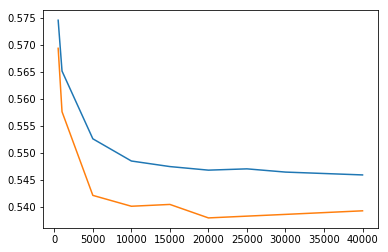

In [69]:
plt.plot(feature_list, cost_list)
plt.plot(feature_list2, cost_list2)

In [11]:
count_vect, X_train_tfidf, y_train, X_test_tfidf, y_test = TF_vectorizer(train, test)

## Work with the mini set for quick testing too

In [11]:
count_vect_mini, X_train_tfidf_mini, y_train_mini, X_test_tfidf_mini, y_test_mini =TF_vectorizer(train_mini, test_mini)

In [19]:
X_train_tfidf_mini.shape

(7244, 20000)

In [20]:
X_train_tfidf.shape

(72444, 20000)

### Extract the additional features designed earlier - these data will need to be scaled

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scalar = StandardScaler()
scalar.fit(np.array([train.overall,train.num_words, train.ARI, train.D_R_sim, train.num_sents]).T)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [12]:
X_train_additional = scalar.transform(np.array([train.overall,train.num_words, train.ARI, train.D_R_sim, train.num_sents]).T)
X_test_additional= scalar.transform(np.array([test.overall,test.num_words, test.ARI, test.D_R_sim, test.num_sents]).T)

In [24]:
X_train_additional_mini = scalar.transform(np.array([train_mini.overall,train_mini.num_words, train_mini.ARI, train_mini.D_R_sim, train_mini.num_sents]).T)
X_test_additional_mini= scalar.transform(np.array([test_mini.overall,test_mini.num_words, test_mini.ARI, test_mini.D_R_sim, test_mini.num_sents]).T)

In [30]:
log_cos =logistic_fit_score(X_train_additional, y_train, X_test_additional, y_test)

train score [0.68978605935127679, 0.68564527260179431, 0.68877691882937608, 0.69166206515737161, 0.68366924351187186]
test score 0.689487632509
Best C [ 0.8]
auc 0.755324624669
confusion [[5704 2092]
 [3532 6784]]


In [33]:
log_cos.coef_

array([[-0.39943856,  0.08047397,  0.41759119,  0.30396855,  0.85192197]])

### Invert sklearn's confusion matrix to conform to a more readable output

In [12]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

## Use cross validation and regularization grid search to determine the best logistic model

In [13]:
def logistic_fit_score(X_train, y_train, X_test, y_test):
    logit = LogisticRegressionCV(Cs=[.8,1,2,3,5], cv=5, n_jobs=-1)
    logit_fit= logit.fit(X_train, y_train)
    scores = [i.mean() for i in logit_fit.scores_[1]]
    pred_prob = logit_fit.predict_proba(X_test)
    pred = logit_fit.predict(X_test)

    print "train score", scores #(X_train, y_train)
    print "test score", logit_fit.score(X_test, y_test)
    print 'Best C', logit_fit.C_
    print "auc", roc_auc_score(y_score=pred_prob[:,1], y_true=y_test)
    print 'confusion', standard_confusion_matrix(y_pred=pred,y_true=y_test)
    return logit_fit

In [14]:
def logistic_fit_score_l1(X_train, y_train, X_test, y_test):
    logit = LogisticRegressionCV(solver = 'liblinear', Cs=[.8,1,2,3,5], cv=5, penalty='l1', n_jobs=-1)
    logit_fit= logit.fit(X_train, y_train)
    scores = [i.mean() for i in logit_fit.scores_[1]]
    pred_prob = logit_fit.predict_proba(X_test)
    pred = logit_fit.predict(X_test)
    print "train score", scores #(X_train, y_train)
    print "test score", logit_fit.score(X_test, y_test)
    print 'Best C', logit_fit.C_
    print 'auc', roc_auc_score(y_score=pred_prob[:,1], y_true=y_test)
    print 'confusion', standard_confusion_matrix(y_pred=pred,y_true=y_test)
    return logit_fit

## Observe the relative predictive strength of the tfidf and the structural features

In [37]:
additional_logit =logistic_fit_score(X_train_additional, y_train, X_test_additional, y_test)

train score [0.68978605935127679, 0.68564527260179431, 0.68877691882937608, 0.69166206515737161, 0.68366924351187186]
test score 0.689487632509
Best C [ 0.8]
auc 0.755324624669
confusion [[5704 2092]
 [3532 6784]]


In [38]:
logreg_result = logistic_fit_score(X_train_tfidf, y_train, X_test_tfidf, y_test)

train score [0.74800552104899931, 0.74456866804692878, 0.74743235781336281, 0.75307840971838769, 0.74255935946990603]
test score 0.757895318021
Best C [ 1.]
auc 0.83546122253
confusion [[6799 1948]
 [2437 6928]]


## Use the count_vectorizor and coefficients of the logistic regression to determine the importaint words

In [39]:
def word_importance(count_vect, logreg):
    
    words = count_vect.get_feature_names()
    feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg.coef_[0])),
    columns = ['feature', 'coef'])

    importaint_words =feature_coefs.sort_values(by='coef')
    return importaint_words

In [40]:
importaint_words= word_importance(count_vect, logreg_result)

In [41]:
importaint_words.tail(5)

,feature,coef
13504,reviewer,3.742950
15887,the,3.786276
693,and,3.786405
1911,basket,3.955525
18033,tuscan,4.632575


In [42]:
importaint_words.head(5)

,feature,coef
3552,coconut oil,-4.641255
1887,barilla,-3.271535
4191,curcumin,-3.163984
18019,turmeric,-3.137662
12169,pamela,-3.098768


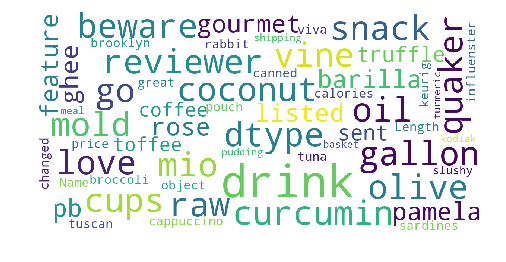

In [44]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(importaint_words["feature"])

### Extract the principal components of the tf_idf vectors - these are for use in

In [14]:
def transformer(model, X_train, X_test):
    fitted =model.fit(X_train)
    X_train_transform = fitted.transform(X_train)
    X_test_transform = fitted.transform(X_test)
    return X_train_transform, X_test_transform, fitted

In [15]:
def pickle_transformer(model, X_train, X_test):
    fitted =model
    X_train_transform = fitted.transform(X_train)
    X_test_transform = fitted.transform(X_test)
    return X_train_transform, X_test_transform, fitted

In [20]:
n_topics = 100
n_top_words = 20
n_features = 1000

In [21]:
from sklearn.decomposition import TruncatedSVD

## Preform Latent Semantic Analysis reducing to 1000 features and the contribution of each

In [24]:
#LSA = TruncatedSVD(n_components=n_features)

In [20]:
import pickle
filename = '4K_lsa_keepers_balanced_2_grams_top_20000.pkl'

In [21]:
LSA=pickle.load(open(filename, 'rb'))

/anaconda/envs/Python27/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [33]:
X_trainT, X_testT, modT = pickle_transformer(LSA, X_train_tfidf, X_test_tfidf)

### Save this LSA transformer for use

In [26]:
#X_trainT_mini, X_testT_mini, modT_mini = transformer(LSA, X_train_tfidf_mini, X_test_tfidf_mini)

In [27]:
#pickle.dump(modT_mini, open(filename, 'wb'))

In [35]:
LSA_20K_4K_9=pickle.load(open('4K_lsa_keepers_balanced_2_grams_top_20000-9.pkl', 'rb'))

/anaconda/envs/Python27/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [33]:
sum(LSA_20K_4K_9.explained_variance_ratio_)

NameError: name 'LSA_20K_4K_9' is not defined

In [41]:
sum(explained_var_1)

0.84400086558950838

In [37]:
explained_var_9=LSA_20K_4K_9.explained_variance_ratio_

In [38]:
explained_var_1 = np.load('exp_var.npy')

In [43]:
np.save(explained_var_1, explained_var_1_4)

NameError: name 'explained_var_1_4' is not defined

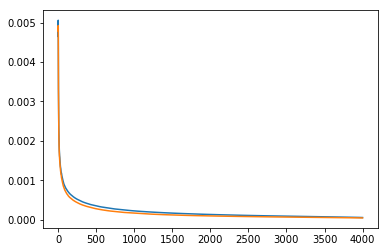

In [40]:
plt.plot(explained_var_1)
plt.plot(explained_var_9)

In [34]:
explained_var=modT.explained_variance_ratio_

In [30]:
type(X_testT)

numpy.ndarray

In [36]:
# train_pkl = 'X_trainT'
# test_pkl = 'X_testT'
# y_train_pkl = 'y_train'
# y_test_pkl = 'y_test'
# explained_var_pkl = 'exp_var'

In [37]:
y_test.shape

(18112,)

In [38]:
np.save(y_train_pkl, y_train)
np.save(y_test_pkl, y_test)
np.save(train_pkl, X_trainT)
np.save(test_pkl, X_testT)
np.save(explained_var_pkl, explained_var)

In [16]:
X_trainT = np.load('X_trainT.npy')
X_testT = np.load('X_testT.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
explained_var = np.load('exp_var.npy')

In [15]:
X_testT = np.load('X_testT.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
explained_var = np.load('exp_var.npy')

In [30]:
AUC_list = pd.read_pickle('AUC_sr.pkl')

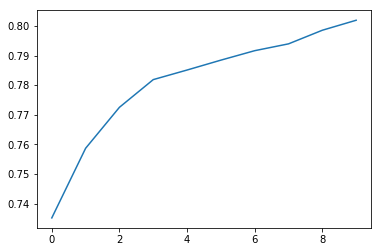

In [32]:
plt.plot(AUC_list)

In [18]:
logit=pickle.load(open('logfit_4000', 'rb'))

/anaconda/envs/Python27/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
logi

# HERE Around a 2K feature cuttoff is where it really flattens out

In [9]:
X_testT =X_testT[:,:2000]
X_trainT = X_trainT[:,:2000]

Use Logistic regression coefs_ to determine the most useful LSAs or PCs for use in tree models

In [ ]:
#logregT=logistic_fit_score(X_trainT, y_train, X_testT, y_test)

In [20]:
abs_coefs =np.absolute(logit.coef_[0])

In [29]:
logit.score(X_testT, y_test)

0.72681095406360419

In [24]:
logit.coef_[0].shape

(4000,)

In [25]:
explained_var.shape

(4000,)

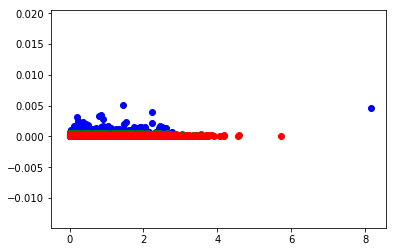

In [28]:
plt.scatter(abs_coefs[:200], explained_var[:200],color='blue')
plt.scatter(abs_coefs[200:1000], explained_var[200:1000],color='green')
plt.scatter(abs_coefs[1000:], explained_var[1000:],color='red')

## Run a random forest on the full set of PCs

In [25]:
def forest_fit_score(X_train, y_train, X_test, y_test):

    forest = RandomForestClassifier(max_features= 'sqrt', oob_score=True, n_estimators=200, min_samples_leaf=4, n_jobs=-1)
    forest_fit= forest.fit(X_train, y_train)
    pred_prob = forest_fit.predict_proba(X_test)
    pred = forest_fit.predict(X_test)
    print "train score", forest.oob_score_
    print "test score", forest_fit.score(X_test, y_test)
    print "auc", roc_auc_score(y_score=pred_prob[:,1], y_true=y_test)
    print 'confusion', standard_confusion_matrix(y_pred=pred,y_true=y_test)
    return forest_fit

In [31]:
from sklearn.model_selection import GridSearchCV
def forest_grid_search(X_train, y_train):
    rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=200, oob_score = True, ) 
    param_grid = { 
    #'n_estimators': [200, 700],
    #'max_features': ['auto', 'sqrt', 'log2']
    'min_samples_leaf': [2,4]}
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
    CV_rfc.fit(X_train, y_train)
    print CV_rfc.best_params_

In [32]:
forest_grid_search(X_train_tfidf, y_train)

{'min_samples_leaf': 2}


In [26]:
TF_idf_forest =forest_fit_score(X_train_tfidf, y_train, X_test_tfidf, y_test)

train score 0.706269670366
test score 0.712676678445
auc 0.785620430391
confusion [[6496 2688]
 [2516 6412]]


### Combine the PCs with the aditional features for use in one model

In [158]:
X_train_comb= np.concatenate((X_trainT, X_train_additional), axis=1)
X_test_comb= np.concatenate((X_testT, X_test_additional), axis=1)

In [159]:
PC_forest =forest_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score 0.721094914693
test score 0.720406360424
auc 0.800967540637
confusion [[6527 2577]
 [2487 6521]]


In [38]:
X_train_comb_mini= np.concatenate((X_trainT_mini, X_train_additional_mini), axis=1)
X_test_comb_mini= np.concatenate((X_testT_mini, X_test_additional_mini), axis=1)

In [138]:
X_train_comb_scaled = scalar.fit_transform(X_train_comb)
X_test_comb_scaled = scalar.transform(X_test_comb)

In [29]:
X_train_comb_mini.shape

(7244, 1005)

In [33]:
from sklearn.svm import SVC

In [ ]:
pred_prob = svm_4_fit.predict_proba(X_test_comb_mini)

In [ ]:
roc_auc_score(y_score=pred_prob[:,1], y_true=y_test_mini)

In [ ]:
import pickle
filename = '1K_lsa_keepers_test_balanced_2_grams_top_50000.pkl'

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
def svm_fit_score(X_train, y_train, X_test, y_test, n=2):
    svm_scaled = SVC(kernel="rbf", C=n, probability=True)
    p_scaled = Pipeline([('scaler', StandardScaler(with_mean=False)),
                      ('svc', svm_scaled)])
    p_scaled.fit(X_train, y_train)
    pred_prob = p_scaled.predict_proba(X_test)
    pred = p_scaled.predict(X_test)
    print 'train_score ', p_scaled.score(X_train, y_train)
    print 'test ', p_scaled.score(X_test, y_test)
    print 'auc', roc_auc_score(y_score=pred_prob[:,1], y_true=y_test)
    print 'confusion', standard_confusion_matrix(y_pred=pred,y_true=y_test)

In [213]:
abs_coefs =np.absolute(coefs[0])

In [209]:
explained_var = modT.explained_variance_

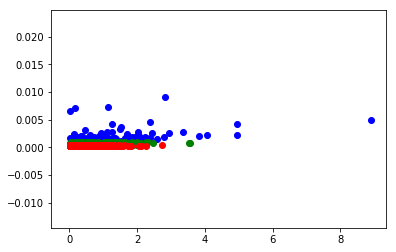

In [289]:
plt.scatter(abs_coefs[:100], explained_var[:100],color='blue')
plt.scatter(abs_coefs[100:500], explained_var[100:500],color='green')
plt.scatter(abs_coefs[500:], explained_var[500:],color='red')

In [ ]:
def LSA_grabber(logreg, X_lsa_train, X_lsa_test, n=20):
    index =logreg.coef_.argsort()[0][-n:]
    return X_lsa_train[:,index], X_lsa_test[:,index]

In [98]:
X_train_trunc, X_test_trunc = LSA_grabber(logreg_fit,X_trainT, X_testT)

In [99]:
forest_fit_score(X_train_trunc, y_train,  X_test_trunc, y_test)

train score 0.702709954387
test score 0.709712037203


Add on LSA description features description, rating and review length, in addition to the most impactful PCs

In [280]:
X_train_trunc.shape

(22362, 20)

In [281]:
X_train_additional.shape

(22362, 2)

In [282]:
X_train_desc_lsa.shape

(22362, 20)

In [283]:
X_train_additional = np.array([train.overall,train.Text_Clean.str.len()]).T
X_test_additional= np.array([test.overall,test.Text_Clean.str.len()]).T

In [284]:
X_train_desc_lsa =np.array(train.lda_desc.apply(pd.Series))
X_test_desc_lsa =np.array(test.lda_desc.apply(pd.Series))

In [303]:
X_train_desc_nmf =np.array(train.nmf_desc.apply(pd.Series))
X_test_desc_nmf =np.array(test.nmf_desc.apply(pd.Series))

In [ ]:
X_trainT, y_train, X_testT, y_test

In [305]:
X_train_comb= np.concatenate((X_train_trunc,X_train_desc_nmf), axis=1)
X_test_comb= np.concatenate((X_test_trunc, X_test_desc_nmf), axis=1)

In [304]:
forest_fit_score(X_train_desc_nmf, y_train, X_test_desc_nmf, y_test)

train score 0.819425811645
test score 0.823466285101


In [306]:
forest_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score 0.792370986495
test score 0.792523698802


Also preform a LSA analysis on the summary tags

In [65]:
X_trainS, X_testS, modS = transformer(LSA, X_train_tfidf_sum, X_test_tfidf_sum)

In [66]:
forest_fit_score(X_trainS, y_train, X_testS, y_test)

train score 0.704468275246
test score 0.705987488829


In [67]:
logistic_fit_score(X_trainS, y_train, X_testS, y_test)

train score [0.75067024128686322, 0.74218051831992859, 0.74678284182305621, 0.74472743521000906, 0.74816800714924037]
test score 0.763538873995


In [68]:
sum(modS.explained_variance_)

0.56614960357464583

Now Combine features, the LSA for summary and body as well as the rating of the review and the length the review and predict 

In [69]:
X_train_additional = np.array([train.overall,train.Text_Clean.str.len()]).T
X_test_additional= np.array([test.overall,test.Text_Clean.str.len()]).T

In [70]:
X_train_comb= np.concatenate((X_trainT, X_trainS, X_train_additional), axis=1)
X_test_comb= np.concatenate((X_testT, X_testS, X_test_additional), axis=1)

In [71]:
forest_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score 0.719079535299
test score 0.717605004468


In [80]:
logistic_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score [0.75884718498659509, 0.74696157283288644, 0.74731903485254692, 0.75504915102770331, 0.75915996425379806]
test score 0.761036639857
[ 0.5]


In [79]:
logistic_fit_score_l1(X_train_comb, y_train, X_test_comb, y_test)

train score [0.75924932975871307, 0.75084897229669356, 0.75142984807864166, 0.74919571045576405, 0.75630026809651474]
test score 0.765147453083
[ 1.]


Now try NMF instead of LSA

In [308]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [309]:
count_vect = CountVectorizer(min_df = 1)
#ngram_range = (1,4)
X_train_counts = count_vect.fit_transform(train["Text_Clean"])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_new_counts = count_vect.transform(test["Text_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [310]:
count_vect_sum = CountVectorizer(min_df = 1)
#ngram_range = (1,4)
X_train_counts_sum = count_vect_sum.fit_transform(train["Summary_Clean"])
X_train_tfidf_sum = tfidf_transformer.fit_transform(X_train_counts)
X_new_counts_sum = count_vect.transform(test["Summary_Clean"])
X_test_tfidf_sum = tfidf_transformer.transform(X_new_counts)

In [311]:
n_topics = 20
n_top_words = 8
n_features = 20

In [312]:
nmf = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5)

In [313]:
X_trainT, X_testT, modT = transformer(nmf, X_train_tfidf, X_test_tfidf)

In [314]:
forest_fit_score(X_trainT, y_train, X_testT, y_test)

train score 0.716617476075
test score 0.715077803613


In [315]:
logistic_fit_score(X_trainT, y_train, X_testT, y_test)

train score [0.688933601609658, 0.6883970489604293, 0.68832737030411439, 0.68810375670840784, 0.6882379248658318]
test score 0.691110713647
[ 100.]


In [227]:
X_trainS, X_testS, modS = transformer(nmf, X_train_tfidf_sum, X_test_tfidf_sum)

In [225]:
# print("\nTopics in NMF model:")
# tfidf_feature_names = count_vect.get_feature_names()
# print_top_words(modT, tfidf_feature_names, n_top_words)

In [228]:
forest_fit_score(X_trainS, y_train, X_testS, y_test)

train score 0.729177837355
test score 0.737622877569


In [229]:
logistic_fit_score(X_trainS, y_train, X_testS, y_test)

train score [0.708981233243968, 0.70826630920464706, 0.7052278820375335, 0.70554066130473636, 0.71090259159964253]
test score 0.725290437891


In [234]:
# print("\nTopics in NMF model:")
# tfidf_feature_names = count_vect_sum.get_feature_names()
# print_top_words(modS, tfidf_feature_names, n_top_words)

Now Combine features, the NMF for summary and body as well as the rating of the review and the length the review and predict 

In [235]:
X_train_additional = np.array([train.overall,train.Text_Clean.str.len()]).T
X_test_additional= np.array([test.overall,test.Text_Clean.str.len()]).T

In [236]:
X_train_comb= np.concatenate((X_trainT, X_trainS, X_train_additional), axis=1)
X_test_comb= np.concatenate((X_testT, X_testS, X_test_additional), axis=1)

In [237]:
forest_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score 0.741331546023
test score 0.748882931189


In [238]:
logistic_fit_score(X_train_comb, y_train, X_test_comb, y_test)

train score [0.71380697050938335, 0.70174262734584447, 0.72582663092046484, 0.71492403932082216, 0.71581769436997322]
test score 0.724754244861


In [253]:
n_topics = 100
n_top_words = 8
n_features = 100

In [255]:
X_trainT, X_testT, modT = transformer(lda, X_train_tfidf, X_test_tfidf)

/anaconda/envs/Python27/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [256]:
forest_fit_score(X_trainT, y_train, X_testT, y_test)

train score 0.655227882038
test score 0.659696157283


In [257]:
logistic_fit_score(X_trainT, y_train, X_testT, y_test)

train score [0.68579088471849858, 0.68619302949061667, 0.6864164432529043, 0.68596961572832882, 0.68561215370866846]
test score 0.690974084004


In [ ]:
X_trainS, X_testS, modS = transformer(nmf, X_train_tfidf_sum, X_test_tfidf_sum)

In [ ]:
forest_fit_score(X_trainS, y_train, X_testS, y_test)

In [ ]:
logistic_fit_score(X_trainS, y_train, X_testS, y_test)

In [ ]:
X_train_additional = np.array([train.overall,train.Text_Clean.str.len()]).T
X_test_additional= np.array([test.overall,test.Text_Clean.str.len()]).T

In [ ]:
X_train_comb= np.concatenate((X_trainT, X_trainS, X_train_additional), axis=1)
X_test_comb= np.concatenate((X_testT, X_testS, X_test_additional), axis=1)

In [ ]:
forest_fit_score(X_train_comb, y_train, X_test_comb, y_test)

In [ ]:
logistic_fit_score(X_train_comb, y_train, X_test_comb, y_test)

In [83]:
# print("\nTopics in LDA model:")
# tf_feature_names = count_vect.get_feature_names()
# print_top_words(modT, tf_feature_names, n_top_words)

In [43]:
# lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
#                                 learning_method='online', learning_offset=50.)

In [44]:
# lda_desc = lda.fit(X_tfidf)

/anaconda/envs/Python27/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [59]:
# print("\nTopics in LDA model:")
# tfidf_feature_names = count_vect.get_feature_names()
# print_top_words(lda_desc, tfidf_feature_names, n_top_words)

In [46]:
# import pickle
# filename = 'lda_desc.pkl'
# pickle.dump(lda_desc, open(filename, 'wb'))

In [ ]:
# loaded_model=pickle.load(open(filename, 'rb))

In [108]:
forest_LSA = forest.fit(X_train_LSA, y_train)

In [109]:
forest_LSA.score(X_train_LSA, y_train)

0.77560321715817693

In [110]:
forest_LSA.score(X_test_LSA, y_test)

0.71581769436997322

In [111]:
X_train_tfidf.shape

(22380, 33142)

In [114]:
sum(LSA.explained_variance_)

0.19697075290662031

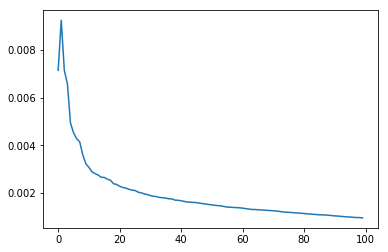

In [115]:
plt.plot(LSA.explained_variance_)

In [116]:
LSA_sum =TruncatedSVD(n_components=100)

In [140]:
def transformer(model, X_train, X_test):
    fitted =model.fit(X_train)
    X_train_transform = fitted.transform(X_train)
    X_test_transform = fitted.transform(X_test)
    return X_train_transform, X_test_transform, fitted

In [138]:
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50)

NameError: name 'LatentDirichletAllocation' is not defined

In [ ]:
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [117]:
LSA_sum.fit(X_train_tfidf_sum)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=None, tol=0.0)

In [118]:
X_train_LSA_sum = LSA_sum.transform(X_train_tfidf_sum)

In [119]:
X_test_LSA_sum = LSA_sum.transform(X_test_tfidf_sum)

In [120]:
LSA_sum.explained_variance_

array([ 0.00714425,  0.0092433 ,  0.00714293,  0.00658641,  0.00493927,
        0.00452665,  0.00428116,  0.00415033,  0.00359942,  0.00323349,
        0.00307587,  0.00289057,  0.00281434,  0.00275467,  0.00266369,
        0.00265413,  0.00258257,  0.00253846,  0.00239029,  0.0023632 ,
        0.00228342,  0.00223612,  0.00220699,  0.0021597 ,  0.00212036,
        0.00210856,  0.00203884,  0.00200888,  0.00196748,  0.0019362 ,
        0.00189664,  0.00186374,  0.00185201,  0.0018136 ,  0.00180569,
        0.00178635,  0.00176028,  0.00175309,  0.0017041 ,  0.00169703,
        0.00167934,  0.00164681,  0.00162643,  0.00162049,  0.00160582,
        0.00159795,  0.00157614,  0.00155529,  0.00154224,  0.0015201 ,
        0.00150437,  0.00148868,  0.00147455,  0.00146341,  0.00143278,
        0.00141155,  0.00140369,  0.00139654,  0.00138691,  0.0013798 ,
        0.00136633,  0.00134343,  0.00133475,  0.00132123,  0.00131487,
        0.0013077 ,  0.00129328,  0.00128764,  0.00127761,  0.00

Add non-tfidf features (in this case the overall rating and the length of the review)

In [121]:
X_train_additional = np.array([train.overall,train.Text_Clean.str.len()]).T
X_test_additional=np.array([test.overall,test.Text_Clean.str.len()]).T

In [122]:
X_train_LSA.shape

(22380, 100)

In [123]:
X_train_LSA_sum_comb= np.concatenate((X_train_LSA,X_train_LSA_sum, X_train_additional), axis=1)

In [124]:
X_test_LSA_sum_comb= np.concatenate((X_test_LSA,X_test_LSA_sum, X_test_additional), axis=1)

In [125]:
forest = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=10, min_samples_leaf=4, n_jobs=400)

In [126]:
forest_LSA_sum_comb= forest.fit(X_train_LSA_sum_comb, y_train)

In [127]:
forest_LSA_sum_comb.score(X_train_LSA_sum_comb, y_train)

0.79445933869526364

In [128]:
forest_LSA_sum_comb.score(X_test_LSA_sum_comb, y_test)

0.72529043789097414

In [100]:
forest.feature_importances_

array([ 0.02954277,  0.05128014,  0.02463637,  0.02355752,  0.15432853,
        0.02299582,  0.02632104,  0.04320699,  0.02195625,  0.04231883,
        0.03047726,  0.04213424,  0.02254527,  0.02317719,  0.06644238,
        0.01975944,  0.02724127,  0.04750741,  0.02938964,  0.03561744,
        0.03963539,  0.1759288 ])

In [27]:
train.head(1)

,asin,reviewText,overall,summary,help_positive,help_total,volume,Ignored,Active,Loved,Hated,Useful,Toxic,Keeper,Text_Clean,Summary_Clean
82926,B004JGQ16I,"The Oreo Fudge Creme cookies are pretty good, ...",4.0,Pretty Good Cookie,0,0,0,1,0,0,0,0,0,1,the oreo fudge creme cookies are pretty good b...,pretty good cookie


In [28]:
X_train_LSA[0]

array([ 0.09774974, -0.03537177,  0.00242888,  0.00823337, -0.01381494,
        0.00285588, -0.01179451,  0.0465412 , -0.08356922,  0.09680838])

In [75]:
ufn_pipe.score(train_ufn["Text_Clean"], train_ufn["Usefulness"])

0.99986795193450417

In [76]:
ufn_pipe.score(test_ufn["Text_Clean"], test_ufn["Usefulness"])

0.70530763137047792

In [99]:
standard_confusion_matrix(y_test ,prediction['Logistic'])

array([[4599, 1684],
       [ 501,  790]])

### Use the title as the description if there is no descjjription - however drop the product if neither is present 

In [7]:
df_food_meta.description.fillna(df_food_meta.title, inplace=True)
df_food_meta = df_food_meta[df_food_meta['description'].notnull()]

In [8]:
df_food_meta.title.fillna(df_food_meta.description, inplace=True)

This will require droping reviews for products with no descriptions/titles at a later point

In [9]:
df_food_meta["Description_Clean"] = df_food_meta['description'].apply(cleanup)

In [10]:
df_food_meta["Title_Clean"] = df_food_meta['title'].apply(cleanup)

In [9]:
#df_food_meta.to_pickle('food_meta_cleaned_train_df.pkl')

In [4]:
df_food_meta = pd.read_pickle('food_meta_cleaned_train_df.pkl')

In [5]:
df_food_meta.shape

(155023, 11)

### Vectorize the cleaned up descriptions

In [6]:
#count_vect = CountVectorizer(min_df = 1, ngram_range=(1,2))
count_vect = CountVectorizer(stop_words= 'english')
X_counts = count_vect.fit_transform(df_food_meta["Description_Clean"])
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

## Try to use PCs as input for K-means

In [13]:
from sklearn.decomposition import TruncatedSVD

In [16]:
SVD = TruncatedSVD(n_components=1000)

In [17]:
SVD_fit = SVD.fit(X_tfidf)

In [42]:
X_PCs = SVD_fit.transform(X_tfidf)

In [19]:
PC_variance=SVD_fit.explained_variance_

In [22]:
sum(PC_variance[:200])

0.23986741845733242

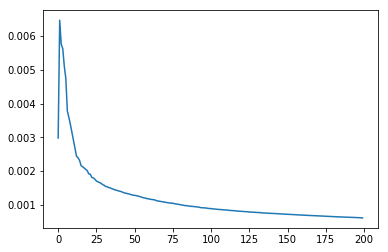

In [23]:
plt.plot(PC_variance[:200])

In [43]:
X_PCs.shape

(155023, 1000)

In [69]:
X_PCs_thresh = X_PCs[:,:25]

In [70]:
X_PCs_thresh.shape

(155023, 25)

#### Try 11 topics - trying to end up with ~5 roughly equal clusters from k-means

In [7]:
n_topics = 6
n_top_words = 15
n_features = 100

In [8]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

As we are looking for non-subtle concrete clusters here some alpha and l1 regularization is a must

In [9]:
nmf = NMF(n_components=n_topics, alpha=.1, l1_ratio=.5)

In [10]:
nmf_desc = nmf.fit(X_tfidf)

In [146]:
#import pickle

In [147]:
# filename = 'nmf_desc_train.pkl'
# pickle.dump(nmf_desc, open(filename, 'wb'))

In [11]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [149]:
print("\nTopics in NMF model:")
tfidf_feature_names = count_vect.get_feature_names()
print_top_words(nmf_desc, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
free organic natural gluten flavor sugar ingredients fat delicious great taste fruit products spices salt
Topic #1:
tea green teas black bags leaves leaf cup herbal blend iced organic loose flavor white
Topic #2:
coffee beans cup roast roasted arabica coffees blend bean flavor rich ground smooth medium single
Topic #3:
pack ounce oz bags mix boxes packages amp count sauce bag box cans original bottles
Topic #4:
product use informational description consult actual possession accurate doctor related matter label note check information
Topic #5:
chocolate milk dark cocoa bar candy gift covered butter bars rich creamy peanut caramel box
()


In [12]:
nmf_values = nmf_desc.transform(X_tfidf)

In [13]:
nmf_values.shape

(155023, 6)

In [14]:
nmf_values[0]

array([ 0.00933572,  0.00295661,  0.00896768,  0.        ,  0.01127982,
        0.00024015])

In [15]:
df_nmf=pd.DataFrame(nmf_values)

In [16]:
import seaborn as sns
sns.set(style="ticks")


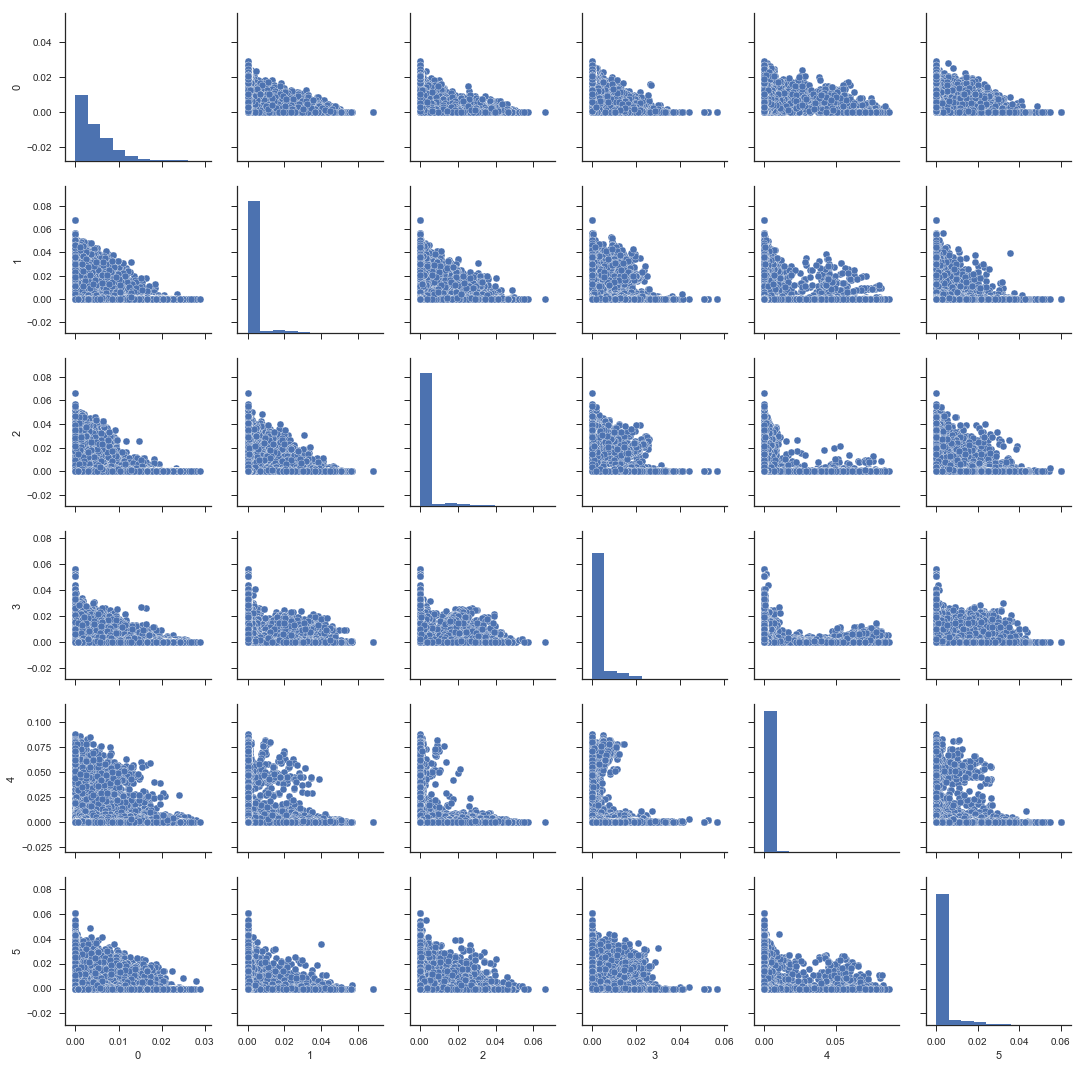

In [17]:
ns.pairplot(df_nmf)

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [20]:
range_n_clusters = [2,3,4,5,6,7,8,9,10]

#### pick a random 5% of the descriptions to determine proper cluster number 

In [22]:
size = nmf_values.shape[0]/20

In [25]:
X = nmf_values[np.random.choice(nmf_values.shape[0],size =size,replace=False)]

In [26]:
X.shape

(7751, 6)

In [37]:
import matplotlib.cm as cm
import seaborn as sn

('For n_clusters =', 2, 'The average silhouette_score is :', 0.77517081004521649)


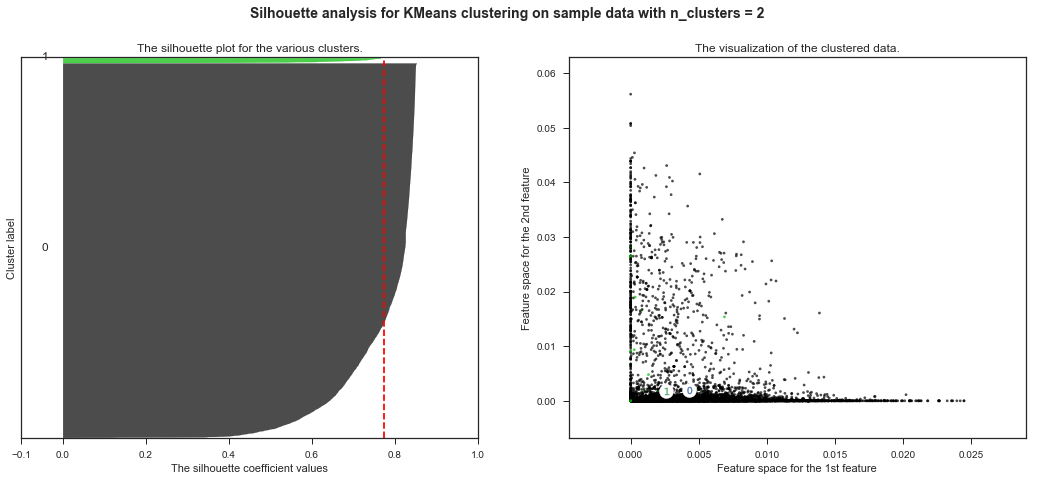

('For n_clusters =', 3, 'The average silhouette_score is :', 0.56822167461109407)


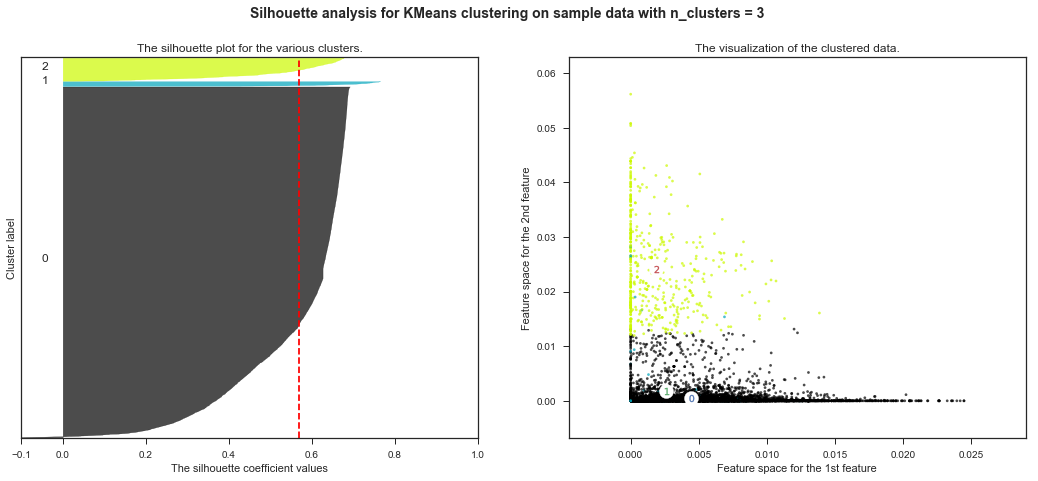

('For n_clusters =', 4, 'The average silhouette_score is :', 0.59190546679364764)


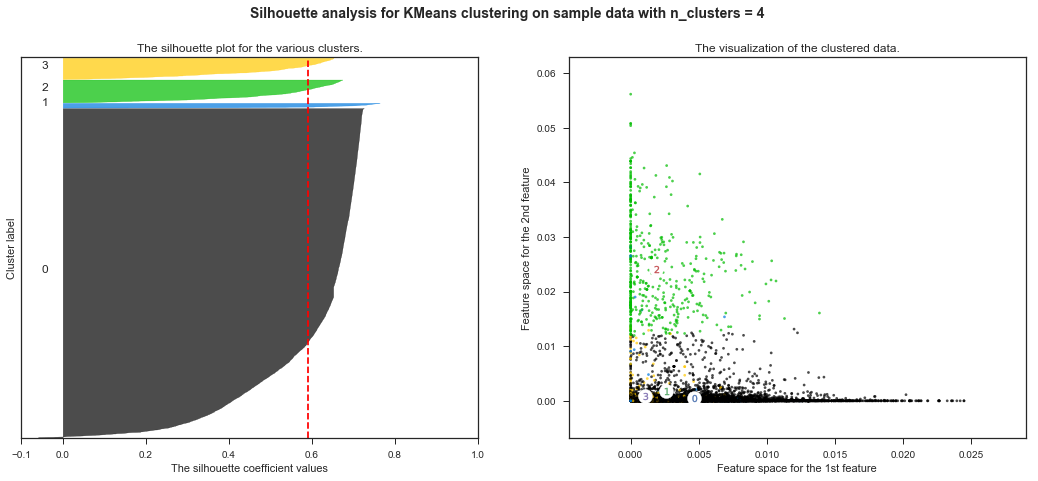

('For n_clusters =', 5, 'The average silhouette_score is :', 0.54469440732466445)


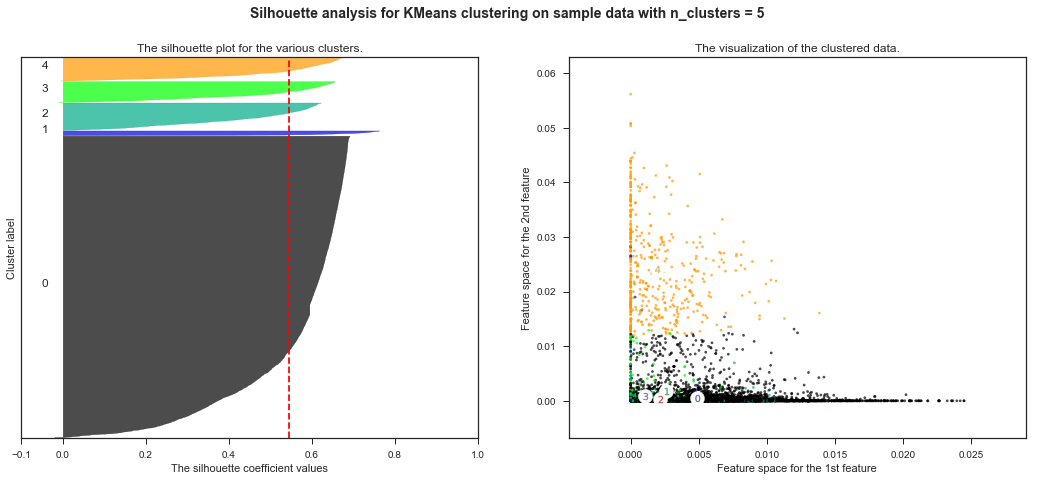

In [38]:
cluster_range = range( 2, 6 )

for n_clusters in cluster_range:
  # Create a subplot with 1 row and 2 columns
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  # The 1st subplot is the silhouette plot
  # The silhouette coefficient can range from -1, 1 but in this example all
  # lie within [-0.1, 1]
  ax1.set_xlim([-0.1, 1])
  # The (n_clusters+1)*10 is for inserting blank space between silhouette
  # plots of individual clusters, to demarcate them clearly.
  ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

  # Initialize the clusterer with n_clusters value and a random generator
  # seed of 10 for reproducibility.
  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X)

  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed
  # clusters
  silhouette_avg = silhouette_score(X, cluster_labels)
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  # Compute the silhouette scores for each sample
  sample_silhouette_values = silhouette_samples(X, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.spectral(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  # The vertical line for average silhoutte score of all the values
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  # 2nd Plot showing the actual clusters formed
  colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  # Labeling the clusters
  centers = clusterer.cluster_centers_
  # Draw white circles at cluster centers
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("Feature space for the 1st feature")
  ax2.set_ylabel("Feature space for the 2nd feature")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

  plt.show()

In [27]:
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

('For n_clusters =', 2, 'The average silhouette_score is :', 0.77517081004521649)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.56822167461109407)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.59190546679364764)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.54469440732466445)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.54004394798484689)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.3900274216251397)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.39410943066422444)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.39725292265134976)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.3810305985842824)


In [29]:
cluster = KMeans(n_jobs=-1,n_clusters = 4, n_init=20)

In [30]:
cluster_fit = cluster.fit(nmf_values)

In [31]:
X_clusters = cluster_fit.predict(nmf_values)

(array([   8811.,  135142.,    9297.,    1773.]),
 array([ 0.  ,  0.75,  1.5 ,  2.25,  3.  ]),
 <a list of 4 Patch objects>)

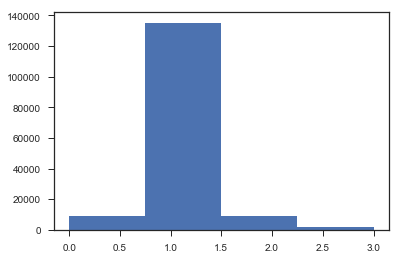

In [32]:
plt.hist(X_clusters, bins=4)

In [80]:
X_clusters.shape

(155023,)

In [81]:
df_food_meta.shape

(155023, 11)

In [82]:
df_food_meta['K_M_catagory'] = X_clusters

Take one of the clusters and see if training on just that cluster gives better scores

In [83]:
df_food_meta_pcs3 =df_food_meta[df_food_meta.K_M_catagory==3]

In [84]:
asin_list = df_food_meta_pcs3.asin.unique()

In [87]:
df_rev_pcs3 = df_food_reviews_working[df_food_reviews_working['asin'].isin(asin_list)]

In [88]:
df_rev_pcs3.shape

(129376, 9)

## For naming shananagins 

In [90]:
df_food_reviews_working = df_rev_pcs3.copy()

In [91]:
df_food_meta =df_food_meta_pcs3.copy()